# Graph structure phase diagram
Phase diagram with number of edges and centralisation.

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'classes'))

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

from news import News
from world import World
from utils import construct_agent_constant_parameters, construct_agents
from agent import AgentState

Function that builds the agents and graph.

In [2]:
def build_graph(num_nodes, number_of_additional_edges, centralisation):
    #make sure number_of_additional_edges edges can be added to the graph
    assert 2 * num_nodes + number_of_additional_edges <= num_nodes*(num_nodes - 1), 'not possible'

    # Nodes
    names = range(num_nodes)
    # Graph
    graph = nx.DiGraph()
    graph.add_nodes_from(names)

    # Connect agents in a Circle in both directions so graph is connected
    if num_nodes > 1:
        graph.add_edge(names[0], names[-1])
        graph.add_edge(names[-1], names[0])
        if num_nodes > 2:
            for i in range(num_nodes - 1):
                graph.add_edge(names[i], names[i + 1])
                graph.add_edge(names[i + 1], names[i])

    # Add additional edges according to centralisation
    current_information_provider = None
    for n in range(number_of_additional_edges):
        if n==0:
            # Choose provider and receiver randomly
            current_information_provider = np.random.choice(names)
            information_receiver = np.random.choice([a for a in names if (a != current_information_provider and (not graph.has_edge(current_information_provider, a)))])
            graph.add_edge(current_information_provider, information_receiver)
        else:
            # Change provider with Probability 1 - centralisation
            if np.random.random() > centralisation:
                current_information_provider = np.random.choice([a for a in names if a != current_information_provider])
            # Make sure receiver can be selected
            while len([a for a in names if (a != current_information_provider and (not graph.has_edge(current_information_provider, a)))]) == 0:
                current_information_provider = np.random.choice([a for a in names if a != current_information_provider])
            #Choose receiver randomly
            information_receiver = np.random.choice([a for a in names if (a != current_information_provider and (not graph.has_edge(current_information_provider, a)))])
            graph.add_edge(current_information_provider, information_receiver)

    # Set weights on edges
    for node in graph.nodes():
        # Set out-degree as weight on out-going edges
        out_degree = graph.out_degree[node]
        for edge in graph.edges(node):
            graph.edges[edge]['weight'] = out_degree

    # Normalize over in-going edges
    for node in graph.nodes():
        sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))
        for edge in graph.in_edges(node):
            graph.edges[edge]['weight'] /= sum_ingoing

    return graph

## First the model parameters are the same for all nodes.

Define function which generates a matrix with percentages of how many agents shared the news for different values of `number_of_additional_edges` and `centralisation`.

In [3]:
def generate_share_map(num_bins=51, factor_for_number_of_additional_edges=10, num_agents=100, sensation=1.0, threshold=0.5, independence=0.5,truth_weight=0.5, graph_samples=10):

    assert 2 * num_agents + (num_bins - 1) * factor_for_number_of_additional_edges <= num_agents*(num_agents - 1), 'not possible'

    numbers_of_additional_edges = np.arange(num_bins) * factor_for_number_of_additional_edges
    centralisation_values = np.linspace(0, 1, num_bins)

    df = pd.DataFrame(columns=['additional edges', 'centralisation', 'number shared'])

    print(f'Starting simulation with {num_agents} agents (this may take some time...)')
    for number_of_additional_edges in numbers_of_additional_edges:
        for centralisation in centralisation_values:
            number_samples = []
            for g_nmb in range(graph_samples):
                graph = build_graph(num_agents, number_of_additional_edges, centralisation)
                news = {1: News(1, sensation, decay_parameter=0.0)}
                agents = construct_agent_constant_parameters(num_agents, threshold, independence, news, graph)
                world = World(agents, news, graph)

                # Activate random agent
                agent = np.random.choice(list(world.agents.values()))
                agent.states[1] = AgentState.ACTIVE

                number_active, _, _ = world.full_dynamics(max_iter=100)

                number_samples.append(number_active / num_agents)

            num_sharing = pd.DataFrame([[number_of_additional_edges, centralisation, np.mean(number_samples)]], columns=df.columns)
            df = df.append(num_sharing, ignore_index=True)
        print(number_of_additional_edges/ (num_bins - 1) / factor_for_number_of_additional_edges)

    print('Simulation completed!!!')

    return df.astype(float).pivot('additional edges', 'centralisation', 'number shared')

### Share Maps

#### Different thresholds

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

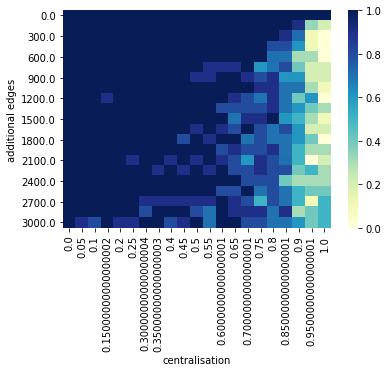

In [4]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, threshold=0.25, independence=0.5,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

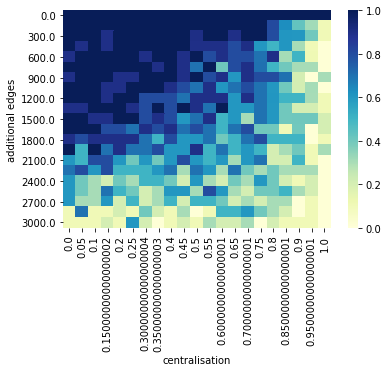

In [5]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

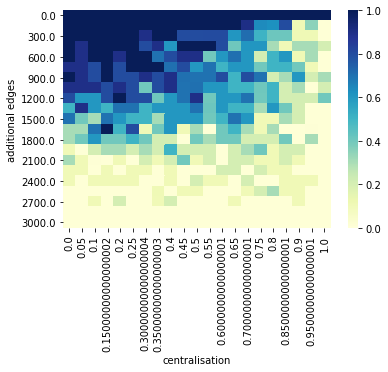

In [6]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, threshold=0.75, independence=0.5,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

#### Different independences

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

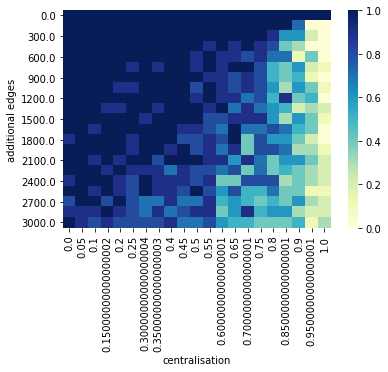

In [7]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, threshold=0.5, independence=0.25,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

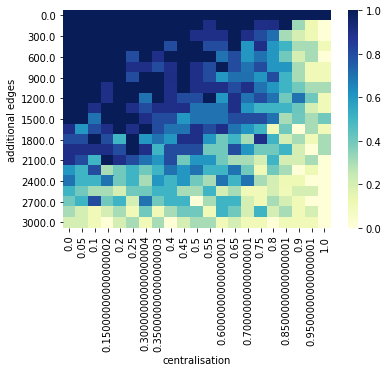

In [8]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

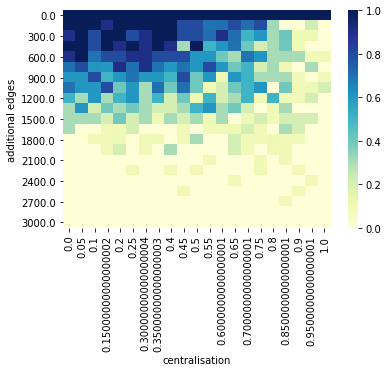

In [9]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, threshold=0.5, independence=0.75,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

#### Different truth_weights

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

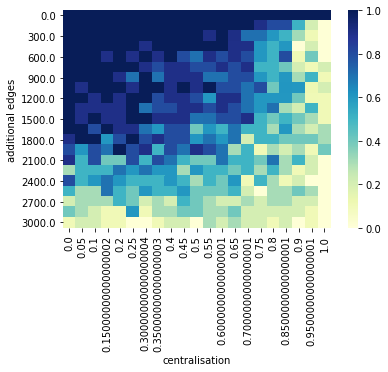

In [10]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.25, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

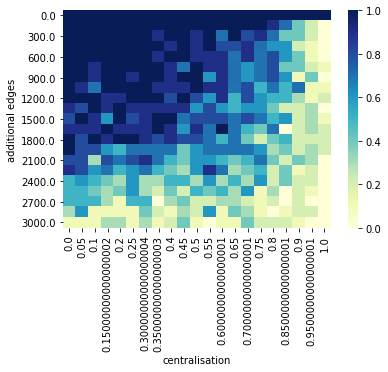

In [11]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

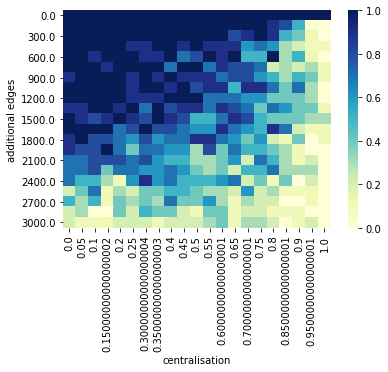

In [12]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.75, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

#### Different sensation

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

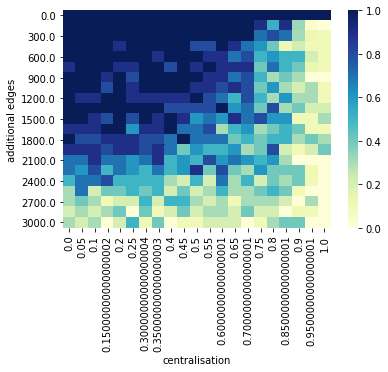

In [13]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)


Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

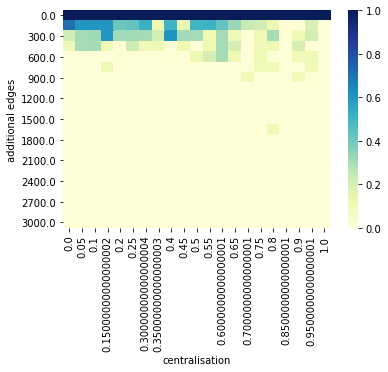

In [14]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.75, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

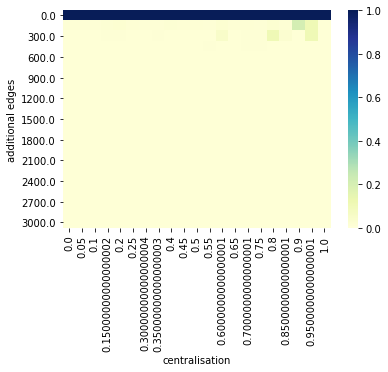

In [15]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.5, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

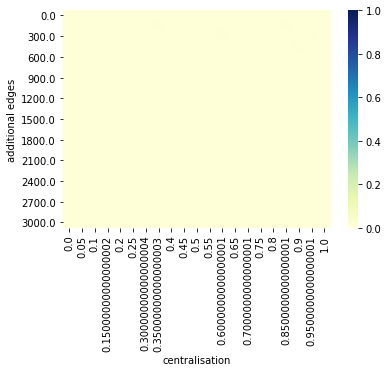

In [16]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.25, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=21)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

### Interpretation

For a simple circle (no additional edges) the weight for the adjacent nodes is always 0.5, so it will spread as likely as possible for a strongly connected graph, but as slow as possible.

For a high concentration, the nodes with a high number of out-going edges will have a high weight, so the news will only spread if the news starts there and then it will spread fast.

For a low concentration all nodes will have similar out-degree and therefore similar weight, news spreading depends on the number of ingoing edges for a node, with a low number the news spreads fast, with a high number
the weight will be too low.

## Now the model parameters are assigned with an uniform distribution.

In [21]:
def generate_share_map(num_bins=51, factor_for_number_of_additional_edges=10, num_agents=100, sensation=1.0, graph_samples=10):

    assert 2 * num_agents + (num_bins - 1) * factor_for_number_of_additional_edges <= num_agents*(num_agents - 1), 'not possible'

    numbers_of_additional_edges = np.arange(num_bins) * factor_for_number_of_additional_edges
    centralisation_values = np.linspace(0, 1, num_bins)

    df = pd.DataFrame(columns=['additional edges', 'centralisation', 'number shared'])

    print(f'Starting simulation with {num_agents} agents (this may take some time...)')
    for number_of_additional_edges in numbers_of_additional_edges:
        for centralisation in centralisation_values:
            number_samples = []
            for g_nmb in range(graph_samples):
                thresholds = np.random.random(num_agents)
                independences = 0.1 * np.random.random(num_agents)
                graph = build_graph(num_agents, number_of_additional_edges, centralisation)
                news = {1: News(1, sensation, decay_parameter=0.0)}
                agents = construct_agents(range(num_agents), thresholds, independences, news, graph)
                world = World(agents, news, graph)

                # Activate random agent
                agent = np.random.choice(list(world.agents.values()))
                agent.states[1] = AgentState.ACTIVE

                number_active, _, _ = world.full_dynamics(max_iter=100)

                number_samples.append(number_active / num_agents)

            num_sharing = pd.DataFrame([[number_of_additional_edges, centralisation, np.mean(number_samples)]], columns=df.columns)
            df = df.append(num_sharing, ignore_index=True)
        print(number_of_additional_edges/ (num_bins - 1) / factor_for_number_of_additional_edges)

    print('Simulation completed!!!')

    return df.astype(float).pivot('additional edges', 'centralisation', 'number shared')

#### Share map for 100 agents, sensation 0.95

In [28]:
share_map = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.95, num_bins=21)

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


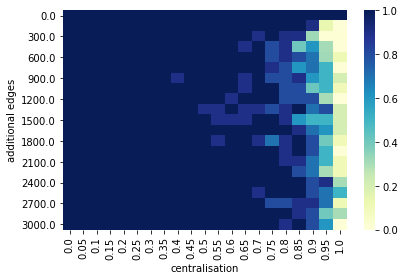

In [29]:
hm = sns.heatmap(share_map, xticklabels=np.float32(np.linspace(0, 1, 21)),cmap='YlGnBu', vmin=0.0, vmax=1.0)
plt.tight_layout()
fig = hm.get_figure()
fig.savefig('heatmap.png', dpi=400)

#### Share map for 100 agents, sensation 0.5

In [30]:
share_map2 = generate_share_map(factor_for_number_of_additional_edges=150, num_agents=100, sensation=0.5, num_bins=21)

Starting simulation with 100 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
Simulation completed!!!


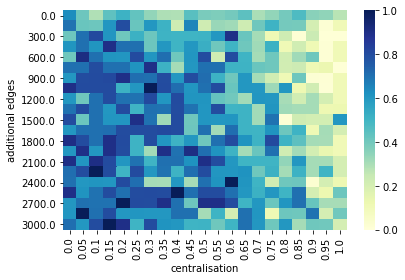

In [34]:
hm2 = sns.heatmap(share_map2, xticklabels=np.float32(np.linspace(0, 1, 21)),cmap='YlGnBu', vmin=0.0, vmax=1.0)
plt.tight_layout()
fig = hm2.get_figure()
fig.savefig('heatmap.png', dpi=400)